In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


## Data Preparation


In [2]:
df = create_dataframe('/../raw_data/dataset_062920.json')
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.49019607843137253, 0.4627450980392157, 0....","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.19607843137254902, 0.1607843137254902, 0....","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.2196078431372549, 0.19215686274509805, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.2196078431372549, 0.17647058823529413, 0....","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.5882352941176471, 0.5647058823529412, 0.6...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


In [3]:
len(df)

846

### Try to use Quaternary encoding to see if we have mislabelled data

In [4]:
# randomly select training examples
x_train, x_validation, y_train, y_validation = create_train_validation(df)

# generate binary y labels
# y_train_binary = create_binary_labels(y_train)
# y_validation_binary = create_binary_labels(y_validation) # generate binary y labels

# generate quaternary y labels
y_train_quaternary = create_quaternary_labels(y_train)
y_validation_quaternary = create_quaternary_labels(y_validation) # generate binary y labels


In [5]:
y_validation_quaternary

,y
2,UR
9,LR
10,LR
11,LR
13,UL
...,...
830,LL
832,UR
834,UL
838,LL


In [6]:
# visualize some data
# plot_eyeImages(x_train,y_train_binary)

In [7]:
# prepare data for feeding in CNN
eyeImage_train, leftEye_train, rightEye_train, quaternary_train = create_tf_data(x_train, y_train_quaternary)
eyeImage_test, leftEye_test, rightEye_test, quaternary_test = create_tf_data(x_validation, y_validation_quaternary)


# encoding the data
# binary_encoder = LabelEncoder()
# binary_encoder.fit(binary_train)
# binary_train = binary_encoder.transform(binary_train)
# binary_test = binary_encoder.transform(binary_test)

# # one-hot encoding the data
# binary_train = to_categorical(binary_train)
# binary_test = to_categorical(binary_test)


In [8]:
quaternary_train

array(['UL', 'UR', 'LL', 'LL', 'LL', 'LR', 'UR', 'LL', 'UR', 'UL', 'UL',
       'LL', 'UR', 'UR', 'LL', 'LR', 'UL', 'UL', 'UL', 'UR', 'LR', 'UR',
       'LR', 'LR', 'LR', 'LR', 'UL', 'LL', 'UR', 'LL', 'LL', 'UL', 'UR',
       'LR', 'LL', 'UL', 'UR', 'LR', 'UL', 'UR', 'UL', 'LL', 'UR', 'LR',
       'LL', 'LL', 'LL', 'UL', 'LL', 'UR', 'UR', 'LR', 'UR', 'UL', 'LL',
       'UR', 'UL', 'LR', 'UL', 'LR', 'UR', 'UL', 'LR', 'UL', 'LL', 'LR',
       'LL', 'UR', 'UR', 'LR', 'LL', 'UL', 'LL', 'UR', 'LL', 'UL', 'UL',
       'LL', 'LL', 'UL', 'LR', 'UL', 'LL', 'UL', 'UL', 'UR', 'UR', 'LR',
       'LL', 'LL', 'LR', 'UR', 'UL', 'LR', 'UR', 'LR', 'UR', 'LR', 'LL',
       'LR', 'UL', 'LL', 'LR', 'LR', 'UR', 'UL', 'UL', 'UR', 'LL', 'LL',
       'UL', 'UR', 'UR', 'UL', 'UL', 'UL', 'LR', 'LR', 'LL', 'LL', 'LL',
       'UR', 'LL', 'LR', 'UL', 'UR', 'LL', 'UL', 'UL', 'UR', 'LR', 'LL',
       'UR', 'LR', 'UL', 'UR', 'UL', 'LR', 'LL', 'LL', 'UL', 'UR', 'UL',
       'LL', 'UR', 'UR', 'UL', 'UR', 'LL', 'LL', 'L

In [9]:
quaternary_encoder = LabelEncoder()
quaternary_encoder.fit(quaternary_train)
quaternary_train = quaternary_encoder.transform(quaternary_train)
quaternary_test = quaternary_encoder.transform(quaternary_test)

# one-hot encoding the data
quaternary_train = to_categorical(quaternary_train)
quaternary_test = to_categorical(quaternary_test)


In [10]:
quaternary_train

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)

## ImageNet V2 Transfer Learning

In [11]:
baseModel = MobileNetV2(input_shape= (224, 224, 3), include_top=False, weights='imagenet')

In [12]:
baseModel.summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

Train the last three layers of the mobilenet

In [13]:
for i in range(144):
    baseModel.layers[i].trainable = False

In [14]:
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4,activation="softmax")(headModel)



In [15]:
model = Model(inputs=baseModel.input, outputs=headModel)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [16]:
model.summary()

k_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 14, 14, 384)  24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]             
__________________________________________________________________________________________________
block_7_expand_relu (ReLU)      (None, 14, 14, 384)  0           block_7_expand

In [17]:
history_1= model.fit(
	x = eyeImage_train,
	y = quaternary_train,
    validation_split=0.2,
    batch_size=32,
	epochs=20)


Epoch 1/20
17/17 [==============================] - 15s 863ms/step - loss: 0.7621 - accuracy: 0.2976 - val_loss: 0.7611 - val_accuracy: 0.2647
Epoch 2/20
17/17 [==============================] - 15s 886ms/step - loss: 0.7374 - accuracy: 0.4529 - val_loss: 0.7583 - val_accuracy: 0.3088
Epoch 3/20
17/17 [==============================] - 14s 818ms/step - loss: 0.7212 - accuracy: 0.5527 - val_loss: 0.7555 - val_accuracy: 0.2794
Epoch 4/20
17/17 [==============================] - 14s 814ms/step - loss: 0.7108 - accuracy: 0.6081 - val_loss: 0.7545 - val_accuracy: 0.2941
Epoch 5/20
17/17 [==============================] - 15s 868ms/step - loss: 0.6967 - accuracy: 0.6802 - val_loss: 0.7526 - val_accuracy: 0.2721
Epoch 6/20
17/17 [==============================] - 15s 881ms/step - loss: 0.6901 - accuracy: 0.7283 - val_loss: 0.7528 - val_accuracy: 0.2794
Epoch 7/20
17/17 [==============================] - 15s 907ms/step - loss: 0.6807 - accuracy: 0.7357 - val_loss: 0.7551 - val_accuracy: 0.3015

KeyboardInterrupt: 

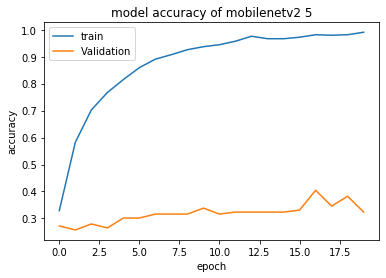

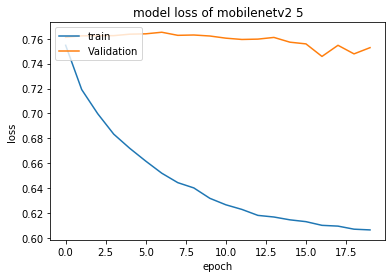

<Figure size 432x288 with 0 Axes>

In [38]:
# summarize history for accuracy
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('model accuracy of mobilenetv2 5')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('results/mobilenetv2_5_acc.png')

# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss of mobilenetv2 5')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('results/mobilenetv2_5_loss.png')


In [39]:
history_2 = model.evaluate(eyeImage_test, quaternary_test)

6/6 [==============================] - 3s 422ms/step - loss: 0.7458 - accuracy: 0.4024


## Updated version of `create_tf_data`, July 1, 2020
Substract every image from the average image, every landmarks from the average landmarks positions

### Get the mean image of the training dataset

In [20]:
mean_image = np.mean(eyeImage_train, axis = 0)
# meadian_image = np.median(eyeImage_train, axis = 0)

NameError: name 'eyeImage_train' is not defined

In [21]:
plt.imshow(mean_image)
# plt.savefig("results/average_img.png")

NameError: name 'mean_image' is not defined

### Updated version of `create_tf_data`

In [22]:
def create_tf_data(X, Y):
    """
    take in the X and Y and transform each column into np array
    Every column in X will be substracted from its mean
    """
    
    eyeImage = np.stack(X['eyeImage'].to_numpy())
    image_mean = np.mean(eyeImage, axis=0)
    eyeImage = eyeImage-image_mean

    leftEye = np.stack(X['leftEye'].to_numpy())
    leftEye_mean = np.mean(leftEye, axis=0)
    leftEye = leftEye-leftEye_mean

    rightEye = np.stack(X['rightEye'].to_numpy())
    rightEye_mean = np.mean(rightEye, axis=0)
    rightEye = rightEye-rightEye_mean

    y = np.stack(Y['y'].to_numpy())
    return eyeImage, leftEye, rightEye, y

### Verify that we substract the mean correctly

In [23]:
_,left,_,_ = create_tf_data(x_train, y_train_binary)

NameError: name 'y_train_binary' is not defined

In [24]:
np.sum(left,axis=0)

NameError: name 'left' is not defined